<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Marc Spiegelman</td>
</table>

In [1]:
%matplotlib inline
import numpy 
import matplotlib.pyplot as plt
import pandas as pd

# Principal Component/EOF analysis

**GOAL:** Demonstrate the use of the SVD to calculate principal components or "Empirical Orthogonal Functions" in a geophysical data set.  This example is modified from a paper by Chris Small (LDEO)

Small, C., 1994. A global analysis of mid-ocean ridge axial topography. Geophys J Int 116, 64–84. [doi:10.1111/j.1365-246X.1994.tb02128.x](https://academic.oup.com/gji/article/116/1/64/638843/A-global-analysis-of-mid-ocean-ridge-axial)


## The Data

Here we will consider a set of topography profiles taken across the global mid-ocean ridge system where the Earth's tectonic plates are spreading apart.
<table>
     <tr align=center><td><img align=center src="./images/world_ocean_topo_green_brown.jpg"><td>
</table>

The data consists of 156 profiles from a range of spreading rates. Each profile contains 79 samples so is in effect a vector in $R^{79}$

In [2]:
# read the data from the csv file
data = pd.read_csv('data/m80_data.csv',header=None).values
data_mean =  numpy.mean(data,0)

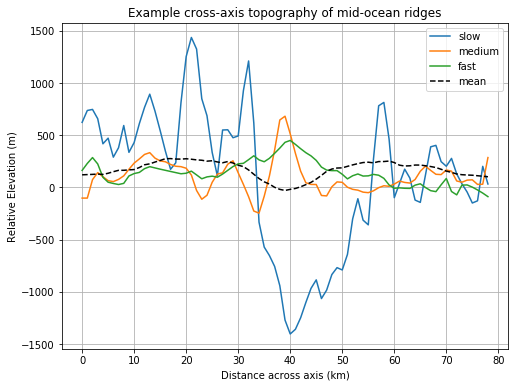

In [3]:
# and plot out a few profiles and the mean depth.
plt.figure(figsize=(8,6))
rows = [ 9,59,99]
labels = [ 'slow','medium','fast']
for i,row in enumerate(rows):
    plt.plot(data[row,:],label=labels[i])
plt.plot(data_mean,'k--',label='mean')
plt.xlabel('Distance across axis (km)')
plt.ylabel('Relative Elevation (m)')
plt.legend(loc='best')
plt.title('Example cross-axis topography of mid-ocean ridges')
plt.grid()
plt.show()

### EOF analysis

While each profile lives in an 80 dimensional space, we would like to see if we can classify the variability in fewer components.  To begin we form a de-meaned data matrix $X$ where each row is a profile.


In [4]:
X = data - data_mean

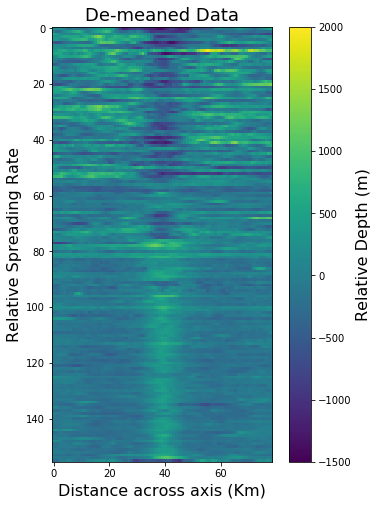

In [5]:
plt.figure(figsize=(6,8))
plt.imshow(X, vmin=-1500, vmax=2000)
plt.xlabel('Distance across axis (Km)', fontsize=16)
plt.ylabel('Relative Spreading Rate', fontsize=16)
plt.title('De-meaned Data', fontsize=18)
cbar = plt.colorbar()
cbar.set_label('Relative Depth (m)', fontsize=16)
plt.show()

### Applying the SVD

We now use the SVD to factor the data matrix as $X = U\Sigma V^T$


In [6]:
# now calculate the SVD of the de-meaned data matrix
U,S,Vt = numpy.linalg.svd(X,full_matrices=False)

And begin by looking at the spectrum of singular values $\Sigma$.  Defining the variance as $\Sigma^2$ then we can also calculate the cumulative contribution to the total variance as 

$$
    g_k = \frac{\sum_{i=0}^k \sigma_i^2}{\sum_{i=0}^n \sigma_i^2}
$$

Plotting both $\Sigma$ and $g$ shows that $\sim$ 80% of the total variance can be explained by the first 4-5 Components

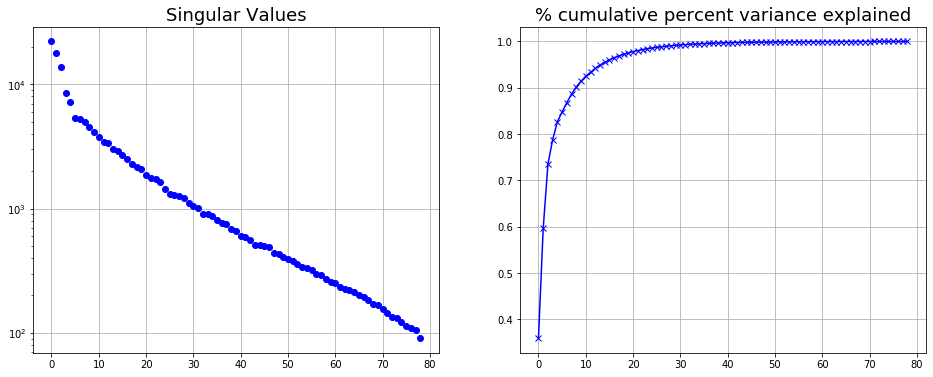

In [9]:
# plot the singular values
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.semilogy(S,'bo')
axes.grid()
axes.set_title('Singular Values', fontsize=18)

# and cumulative percent of variance
axes = fig.add_subplot(1, 2, 2)
g = numpy.cumsum(S*S)/numpy.sum(S*S)
axes.plot(g,'bx-')

axes.set_title('% cumulative percent variance explained', fontsize=18)
axes.grid()

plt.show()

Plotting the first 3 Singular Vectors in $V$,  shows them to reflect some commonly occuring patterns in the data

In [16]:
num_EOFs=3

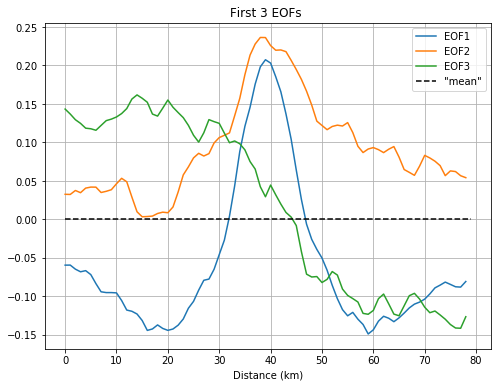

In [23]:
fig = plt.figure(figsize=(8, 6))

axes = fig.add_subplot(1, 1, 1)
for row in range(num_EOFs):
    axes.plot(Vt[row,:],label='EOF{}'.format(row+1))

axes.plot([0, X.shape[1]], [0., 0.], 'k--', label='"mean"')
    
axes.grid()
axes.set_xlabel('Distance (km)')
axes.set_title('First {} EOFs '.format(num_EOFs))
axes.legend(loc='best')


plt.show()

Note:
- Each EOF is a unit vector
- EOF1 accounts for the most variance of data (compared to other EOFs)

For example,  the first EOF pattern is primarily a symmetric pattern with an axial high surrounded by two off axis troughs (or an axial low with two flanking highs,  the EOF's are just unit vector bases for the row-space and can be added with any positive or negative coefficient).  The Second EOF is broader and all of one sign while the third EOF encodes assymetry.

### Reconstruction

Using the SVD we can also decompose each profile into a weighted linear combination of EOF's i.e.

$$
    X = U\Sigma V^T = C V^T
$$

where $C = U\Sigma$ is a matrix of coefficients  that describes the how each data row is decomposed into the relevant basis vectors.  We can then produce a k-rank truncated representation of the data by

$$ 
    X_k = C_k V_k^T
$$

where $C_k$ is the first $k$ columns of $C$ and $V_k$ is the first $k$ EOF's.  

Here we show the original data and the reconstructed data using the first 5 EOF's

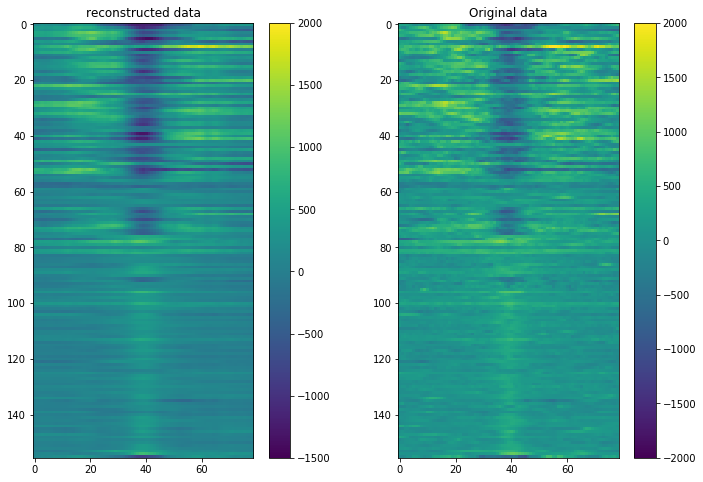

In [19]:
# recontruct the data using the first 5 EOF's
k=5
Ck = numpy.dot(U[:,:k],numpy.diag(S[:k]))
Vtk = Vt[:k,:]
data_k = data_mean + numpy.dot(Ck,Vtk)

fig = plt.figure(figsize=(12, 8))
axes = fig.add_subplot(1,2,1)
im = axes.imshow(data_k, vmin=-1500, vmax=2000)
fig.colorbar(im)
axes.set_title('reconstructed data')

axes = fig.add_subplot(1, 2, 2)
im = axes.imshow(data, vmin=-2000, vmax=2000)
axes.set_title('Original data')
fig.colorbar(im)
plt.show()


And we can consider a few reconstructed profiles compared with the original data

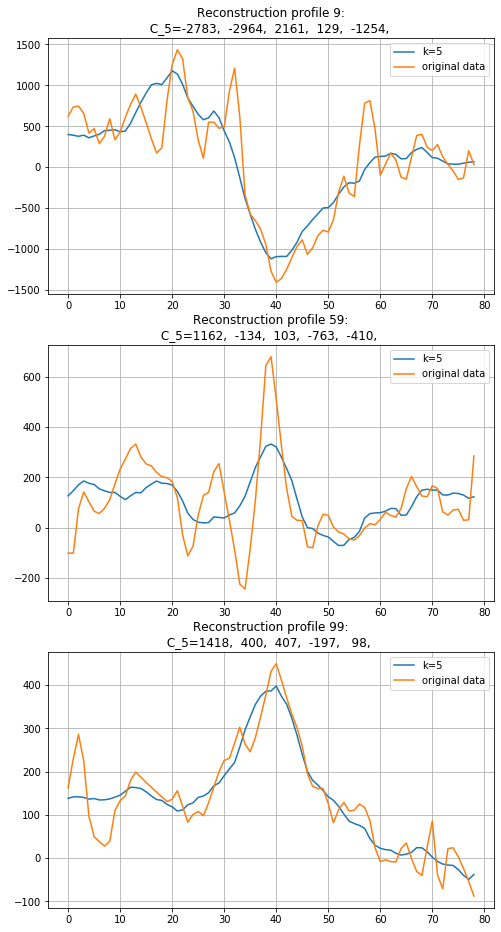

In [20]:
# show the original 3 profiles and their recontructed values using the first k EOF's
fig = plt.figure(figsize=(8,16))

for i,row in enumerate(rows):
    axes = fig.add_subplot(3, 1, i+1)
    h = axes.plot(data_k[row,:])
    h += axes.plot(data[row,:])
    axes.grid()
    Cstring = [ '{:3.0f},  '.format(Ck[row,i]) for i in range(k) ]
    axes.set_title('Reconstruction profile {}:\n C_{}='.format(row,k)+''.join(Cstring))
    axes.legend(['k={}'.format(k), 'original data'], loc='best')

plt.show()    

## projection of data onto a subspace

We can also use the Principal Components to look at the projection of the data onto a lower dimensional space as the coefficients $C$, are simply the coordinates of our data along each principal component.  For example we can view the data in the 2-Dimensional space defined by the first 2 EOF's by simply plotting C_1 against C_2.

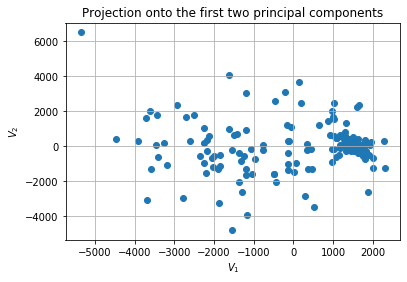

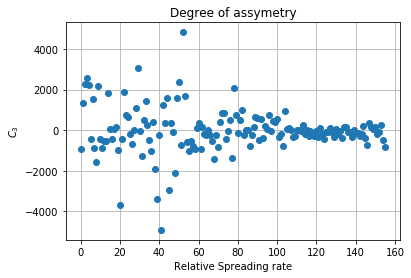

In [21]:
# plot the data in the plane defined by the first two principal components
plt.figure()
plt.scatter(Ck[:,0],Ck[:,1])
plt.xlabel('$V_1$')
plt.ylabel('$V_2$')
plt.grid()
plt.title('Projection onto the first two principal components')
plt.show()

# Or consider the degree of assymetry (EOF 3) as a function of spreading rate
plt.figure()
plt.plot(Ck[:,2],'o')
plt.xlabel('Relative Spreading rate')
plt.ylabel('$C_3$')
plt.grid()
plt.title('Degree of assymetry')
plt.show()